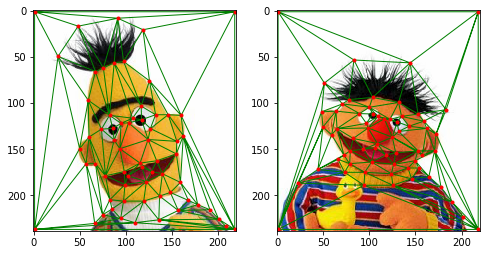

# Trip Generation


In this assignment, you will develop a function to Trip Generate. As with previous assignments, you should avoid writing any code that explicitly loops over pixels in the image.

---

## Part 1) Extract CSV
---

In [1]:
import csv

students = []
isStudent3Units = {}
trips = set([])
prefs = {}
indices = {}

FIRST_NAME = 'First Name'
LAST_NAME = 'Last Name'
CHOICE_COL_NAMES = ['First Choice - Field Trip',
                    'Second Choice - Field Trip',
                    'Third Choice - Field Trip',
                    'Fourth Choice - Field Trip',
                    'Fifth Choice - Field Trip']
UNITS = 'How many units are you registered for?'

with open('spring_22_general.csv') as file:
    reader = csv.reader(file, delimiter=',', quotechar='|')
    for i, row in enumerate(reader):
        # print(row)
        if i == 0:
            for j, title in enumerate(row):
                # print(j, title)
                indices[title] = j
        if i > 0:
            # print('row', row)
            # print(indices[FIRST_CHOICE])
            student = row[indices[FIRST_NAME]] + ' ' + row[indices[LAST_NAME]]
            prefList = []
            for col_name in CHOICE_COL_NAMES:
                val = row[indices[col_name]]
                if val in prefList:
                    print('duplicate preference found for student:', student, 'ignoring entry')
                    continue
                if val == '':
                    raise ValueError('Student "' + student + '" missing preference, fix in sheet and rerun')
                prefList.append(val)
            prefs[student] = prefList
            if student in students:
                print('duplicate student found:', student, 'removing previous entry')
                students.remove(student)
            students.append(student)
            isStudent3Units[student] = 1 if row[indices[UNITS]] == '3' else 0
            for t in prefs[student]:
                trips.add(t)
    # print(prefs)
    trips = sorted(list(trips))
    print(trips)
# print(students)

duplicate preference found for student: Vivian Auduong ignoring entry
duplicate preference found for student: Catherine Dickerman ignoring entry
duplicate preference found for student: Esther Filipek ignoring entry
duplicate preference found for student: Jenna Ruzekowicz ignoring entry
duplicate preference found for student: Amanda So ignoring entry
['1. Lodi Energy Center Tuesday 4/19 6:45am - 2:30pm', '10. UC Davis: 1. Renewable Energy Anaerobic Digester 2. Solar Farm 3. Lighting Tech Center Tuesday 5/24 7:00am - 3:30pm', '2. Exploratorium SF Saturday 4/23 8:15am -2:00pm', '3. San Ardo Oil Field Tuesday 4/26 6:45am - 5:00pm', '4. Black Diamond Coal Mines Saturday 4/30 8:15am - 2:15pm', '5. Proterra Tuesday 5/3 1:00pm - 5:00pm', '6. Tesla Fremont Factory Thursday 5/5 9:30am - 1:15pm', '7. Tesla Gigafactory 1 Tuesday 5/10 7:15am - 8:30pm', '8. NextEra Altamont Pass Wind Energy Project Thursday 5/12 7:00am - 1:15pm', '9. Folsom Hydroelectric Dam Powerhouse Saturday 5/21 8:00am - 4:30pm'

### Part 2) Scoring Function

---


In [2]:
import numpy as np
from collections import defaultdict

TRIP_MAX_FOUR_UNITS = 2
TRIP_MAX_THREE_UNITS = 1
EV_MAX = 1
TRIP_PPL_MAX = np.array([29, 45, 14, 30, 45, 29, 11, 9, 25, 50]) - np.array([0, 0, 5, 1, 9, 0, 1, 0, 1, 5,])
EV_TRIPS = np.array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0])
STARTING_SCORE = 10
SCORE_DECAY_FACTOR = 0.5
SINGLE_TRIP_FACTOR = 1.5
MAX_NUM_TRIPS = len(trips)
SCORE_WEIGHTS_2 = [STARTING_SCORE * SCORE_DECAY_FACTOR ** i for i in range(MAX_NUM_TRIPS)]
SCORE_WEIGHTS_1 = [SINGLE_TRIP_FACTOR * STARTING_SCORE * SCORE_DECAY_FACTOR ** i for i in range(MAX_NUM_TRIPS)]
CAPACITY_PENALTY_FACTOR = 20
PER_STUDENT_PENALTY_FACTOR = np.sum(np.array(SCORE_WEIGHTS_2)) + 5
EV_OVERFLOW_PENALTY_FACTOR = 20

ev_trip_assignment_tile = np.tile(EV_TRIPS, len(students))
ev_trip_assignment_tile = np.reshape(ev_trip_assignment_tile, (-1, len(EV_TRIPS)))

per_student_max = []
for student in students:
    per_student_max.append(TRIP_MAX_THREE_UNITS if isStudent3Units[student] else TRIP_MAX_FOUR_UNITS)
per_student_max = np.reshape(np.array(per_student_max), (-1, len(students)))
print(per_student_max.shape)

demand_per_trip = defaultdict(int)
for (student, student_prefs) in prefs.items():
    for pref in student_prefs:
        demand_per_trip[pref] += 1
print(demand_per_trip)

def make_pref_matrix(prefs):
    mat = np.zeros((len(students), MAX_NUM_TRIPS))
    for row, (student, prefs) in enumerate(prefs.items()):
        # print('student', student)
        for col, pref in enumerate(prefs):
            prefIndex = trips.index(pref)
            mat[row][prefIndex] = SCORE_WEIGHTS_2[col]
            # print('r:', row, 'c:', col, 'pref:', pref, prefIndex)
        # print(mat[row])
    return mat

def score_matrix(pref_mat, assignment_mat, debug=False):
    # Score for assigning people to trips they select as their preference
    trip_score = np.sum(np.sum(np.multiply(pref_mat, assignment_mat)))

    # Penalty for assigning more than alloted capacity for a trip
    diff = (np.sum(assignment_mat, axis=0) - TRIP_PPL_MAX)
    zero = np.zeros(assignment_mat.shape[1])
    capacity_penalty = CAPACITY_PENALTY_FACTOR * np.maximum(diff, zero).sum()

    # Penalty for assigning one student to more than 1/2 trips
    diff = (np.sum(assignment_mat, axis=1) - per_student_max)
    per_student_penalty = PER_STUDENT_PENALTY_FACTOR * np.abs(diff).sum()
    if debug:
        print('assignment', assignment_mat)
        print('per_student', np.maximum(diff, zero))
    # print(trip_score, capacity_penalty, per_student_penalty)

    # Penalty for assigning one student to more than 1 EV trip
    ev_only_assignment_mat = np.logical_and(ev_trip_assignment_tile, assignment_mat)
    diff = (np.sum(ev_only_assignment_mat, axis=1) - EV_MAX)
    zero = np.zeros(assignment_mat.shape[0])
    ev_student_penalty = EV_OVERFLOW_PENALTY_FACTOR * np.maximum(diff, zero).sum()

    students_on_each_trip = np.sum(assignment_mat, axis=0)


    return trip_score - capacity_penalty - per_student_penalty - ev_student_penalty

def evaluate_matrix(pref_mat, assignment_mat):
    # Score for assigning people to trips they select as their preference
    trip_score = np.sum(np.sum(np.multiply(pref_mat, assignment_mat)))

    # Penalty for assigning more than alloted capacity for a trip
    diff = (np.sum(assignment_mat, axis=0) - TRIP_PPL_MAX)
    zero = np.zeros(assignment_mat.shape[1])
    capacity_penalty = CAPACITY_PENALTY_FACTOR * np.maximum(diff, zero).sum()

    # Penalty for assigning one student to more than 1/2 trips
    diff_per = (np.sum(assignment_mat, axis=1) - per_student_max)
    per_student_penalty = PER_STUDENT_PENALTY_FACTOR * np.abs(diff_per).sum()

    # Penalty for assigning one student to more than 1 EV trip
    ev_only_assignment_mat = np.logical_and(ev_trip_assignment_tile, assignment_mat)
    diff = (np.sum(ev_only_assignment_mat, axis=1) - EV_MAX)
    zero = np.zeros(assignment_mat.shape[0])
    ev_student_penalty = EV_OVERFLOW_PENALTY_FACTOR * np.maximum(diff, zero).sum()

    students_on_each_trip = np.sum(assignment_mat, axis=0)
    trip_score = np.sum(np.sum(np.multiply(pref_mat, assignment_mat)))
    students_on_each_trip = np.sum(assignment_mat, axis=0)
    trips_per_student = np.sum(assignment_mat, axis=1)
    print('\nTotal trip score:', trip_score)
    print('\nCapacity penalty:', capacity_penalty)
    print('\nStudnet overflow penalty:', per_student_penalty)
    print('\nDifference between assigned field trips and # meant to go on', diff_per)
    print('\nEV penalty:', ev_student_penalty)
    print('\nStudents on each trip', students_on_each_trip)
    print('\nTrips per student:', trips_per_student)

def score_student(prefs, trips):
    """ Calculates score for single student given trip assignment.
    """
    total = 0
    for pref, score in zip(prefs, SCORE_WEIGHTS_2):
        if pref in trips:
            total += score
    return total

def score_students(prefs, assignments):
    """ Calculates score for assignment for whole class
    """
    total = 0
    for student, pref in prefs.items():
        total += score_student(pref, assignments[student])
    return total
pref_mat = make_pref_matrix(prefs)

(1, 107)
defaultdict(<class 'int'>, {'5. Proterra Tuesday 5/3 1:00pm - 5:00pm': 58, '4. Black Diamond Coal Mines Saturday 4/30 8:15am - 2:15pm': 64, '6. Tesla Fremont Factory Thursday 5/5 9:30am - 1:15pm': 80, '8. NextEra Altamont Pass Wind Energy Project Thursday 5/12 7:00am - 1:15pm': 75, '1. Lodi Energy Center Tuesday 4/19 6:45am - 2:30pm': 41, '7. Tesla Gigafactory 1 Tuesday 5/10 7:15am - 8:30pm': 56, '3. San Ardo Oil Field Tuesday 4/26 6:45am - 5:00pm': 23, '9. Folsom Hydroelectric Dam Powerhouse Saturday 5/21 8:00am - 4:30pm': 48, '2. Exploratorium SF Saturday 4/23 8:15am -2:00pm': 52, '10. UC Davis: 1. Renewable Energy Anaerobic Digester 2. Solar Farm 3. Lighting Tech Center Tuesday 5/24 7:00am - 3:30pm': 33})


### Part 3) Make assignment

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pygad

GA_POPULATION = 500
NUM_PARENTS_MATING = GA_POPULATION // 10
N_GENERATIONS = 250000
PARENT_SELECTION_TYPE = "sss"
MUTATE_FRACTION = len(students) * MAX_NUM_TRIPS * 7.71604938e-6
# MUTATE_FRACTION = len(students) * MAX_NUM_TRIPS * .0001

def get_random_assignment():
    assignments = np.full((len(students), MAX_NUM_TRIPS), False)
    for row in assignments:
        # continue
        two = np.random.permutation(assignments.shape[1])[:5]
        row[two[0]] = True
        row[two[1]] = True
    return assignments
def genetic_solve(num_generations, eval_point, parent_type):
    pref_mat = make_pref_matrix(prefs)
    def fitness_func(solution, solution_idx):
        return score_matrix(pref_mat, np.reshape(solution, (-1, pref_mat.shape[1])), debug=False)

    points = []
    for _ in range(GA_POPULATION):
        points.append(get_random_assignment().flatten())

    def callback_generation(ga_instance):
        if ga_instance.generations_completed % (N_GENERATIONS/10) == 0:
            print('first few lines:', ga_instance.best_solution()[0][:25])
            print("Generation = {generation}".format(generation=ga_instance.generations_completed))
            print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
            # print("Change     = {change}".format(change=ga_instance.best_solution()[1] - last_fitness))
            # last_fitness = ga_instance.best_solution()[1]
    
    def mutation_func(offspring, ga_instance):
        for row in range(offspring.shape[0]):
            # score_before = score_matrix(pref_mat, np.reshape(offspring[row], (-1, pref_mat.shape[1])))
            num_to_mutate = int(offspring[row].size * MUTATE_FRACTION)
            random_gene_indexes = np.random.randint(0, offspring[row].size, num_to_mutate)
            offspring[row, random_gene_indexes] = 1 - offspring[row, random_gene_indexes]
            # score_after = score_matrix(pref_mat, np.reshape(offspring[row], (-1, pref_mat.shape[1])))
            # if score_before < score_after:
                # print('before', score_before, 'after', score_after)
            
        return offspring
    # Creating an instance of the GA class inside the ga module. Some parameters are initialized within the constructor.
    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=NUM_PARENTS_MATING, 
                        fitness_func=fitness_func,
                        on_generation=callback_generation,
                        parent_selection_type=parent_type,
                        initial_population=points,
                        mutation_type=mutation_func,
                        )

    # Running the GA to optimize the parameters of the function.
    ga_instance.run()

    # After the generations complete, some plots are showed that summarize the how the outputs/fitenss values evolve over generations.
    ga_instance.plot_fitness()

    # Returning the details of the best solution.
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    # FIXME: uncomment        
    print("Parameters of the best solution : {solution}".format(solution=np.reshape(solution, (-1, pref_mat.shape[1]))))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))
    if ga_instance.best_solution_generation != -1:
        print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))
    return ga_instance.best_solution()

mutation_rates = ['sss', 'tournament']
def optimizeGA(objective, descent):
    pref_mat = make_pref_matrix(prefs)

    grid = []
    for mutation_rate in mutation_rates:
        continue
        print('running mutation_rate with rate:', mutation_rate)
        l = []
        for i in range(2):
            solution, solution_fitness, solution_idx = descent(N_GENERATIONS, objective, mutation_rate)
            l.append(solution_fitness)
            print('got fitness:', solution_fitness)
        avg = sum(l)/len(l)
        grid.append(([mutation_rate, avg], l))
    solution, solution_fitness, solution_idx = descent(N_GENERATIONS, objective, 'sss')
    print('grid', grid)
    evaluate_matrix(pref_mat, np.reshape(solution, (-1, pref_mat.shape[1])))
    return solution, solution_fitness
h1 = (optimizeGA(score_matrix, genetic_solve))
h0=["Step Sizes"]
h0.append("Minimum")
h0.append("Time List")
h0.append("Number of evals")
print(h1)
print(make_pref_matrix(prefs))

first few lines: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
Generation = 25000
Fitness    = 505.05859375
first few lines: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
Generation = 50000
Fitness    = 528.80859375
first few lines: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0.]
Generation = 75000
Fitness    = 533.80859375
first few lines: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
Generation = 100000
Fitness    = 555.68359375
first few lines: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
Generation = 125000
Fitness    = 562.55859375
first few lines: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
Generation = 150000
Fitness    = 562.55859375
first few lines: [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
Generation = 175000
Fitness    = 567.578125


KeyboardInterrupt: 

### Part 4) Analyze & Output to CSV

In [ ]:
import csv
from collections import defaultdict
print(np.array(trips).shape)
sol = np.reshape(h1[0], (-1, pref_mat.shape[1])).astype(np.int64)
evaluate_matrix(pref_mat, np.reshape(sol, (-1, pref_mat.shape[1])))
print(sol.shape)

# tripsOutput = np.insert(sol, 0, trips, 0)
# print(tripsOutput)
with open('sample.csv', 'w') as f:
    f.write('Student name,' + ','.join(trips) + '\n')
    for i, line in enumerate(sol):
        f.write(students[i] + ',')
        line = line.tolist()
        line = [str(x) for x in line]
        # print(line)
        f.write(','.join(line) + '\n')

def print_statistics(students_per_preference, total_trips):
    ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
    accounted_for_students = 0
    for preference, number in students_per_preference.items():
        # print('pref, numb', preference, number)
        percentage = number / total_trips
        accounted_for_students += number
        print('{0}% of slots were student\'s {1} choice'.format(round(percentage, 4)*100, ordinal(preference)))
    excess = round( (total_trips - accounted_for_students) / total_trips, 4) * 100
    print('{0}% of slots were student\'s 6+ choice'.format(excess))

with open('sample3.csv', 'w') as f:
    total_trips = 0
    students_per_preference = defaultdict(int)
    for i in range(5):
        students_per_preference[i] = 0
    f.write('Student name,' + ','.join([f'Pref {i}' for i in range(1, 6)]) + '\n')
    print(f'Pref {i}, ' for i in range(1,6))
    for row, (student, student_prefs) in enumerate(prefs.items()):
        # Count up all possible trips for students
        if isStudent3Units[student]:
            total_trips += 1
        else:
            total_trips += 2
        f.write(students[row] + ',')
        for col, pref in enumerate(student_prefs):
            prefIndex = trips.index(pref)
            if sol[row][prefIndex]:
                students_per_preference[col+1] += 1
                f.write('1,')
            else:
                f.write('0,')
            # print('r:', row, 'c:', col, 'pref:', pref, prefIndex)
        f.write('\n')
    print(students_per_preference, total_trips)
    print_statistics(students_per_preference, total_trips)

(10,)

Total trip score: 570.0

Capacity penalty: 0.0

Studnet overflow penalty: 149.8828125

Difference between assigned field trips and # meant to go on [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]

EV penalty: 0.0

Students on each trip [29 23  8 18 28 22  9  9 22 32]

Trips per student: [2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2
 2 2 2 2 2 1 2 2 1 2 3 2 2 2 2 1 2 2 2 1 2 3 1 2 2 2 2 3 1 1 2 2 3 2 2 2 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2 2 3 1 1 2 2 2 2 2 2 2 2 2 1]
(107, 10)
<generator object <genexpr> at 0x00000153A6CED850>
defaultdict(<class 'int'>, {0: 0, 1: 36, 2: 20, 3: 24, 4: 31, 5: 18}) 194
0.0% of slots were student's 0th choice
18.56% of slots were student's 1st choice
10.31% of slots were student's 2nd choice
12.370000000000001% of slots were student's 3rd choice